In [1]:
import data_utils as du
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import compress
import scipy

from matplotlib_venn import venn2

from utils.data import load_PPMI_data

data_dir = du.find_data_dir('app')
dataloader_file = du.get_file_path(data_dir, 'class based structure', 'dataloaders', 'dataloader.p')
dataloader = du.read_from_pickle(dataloader_file)

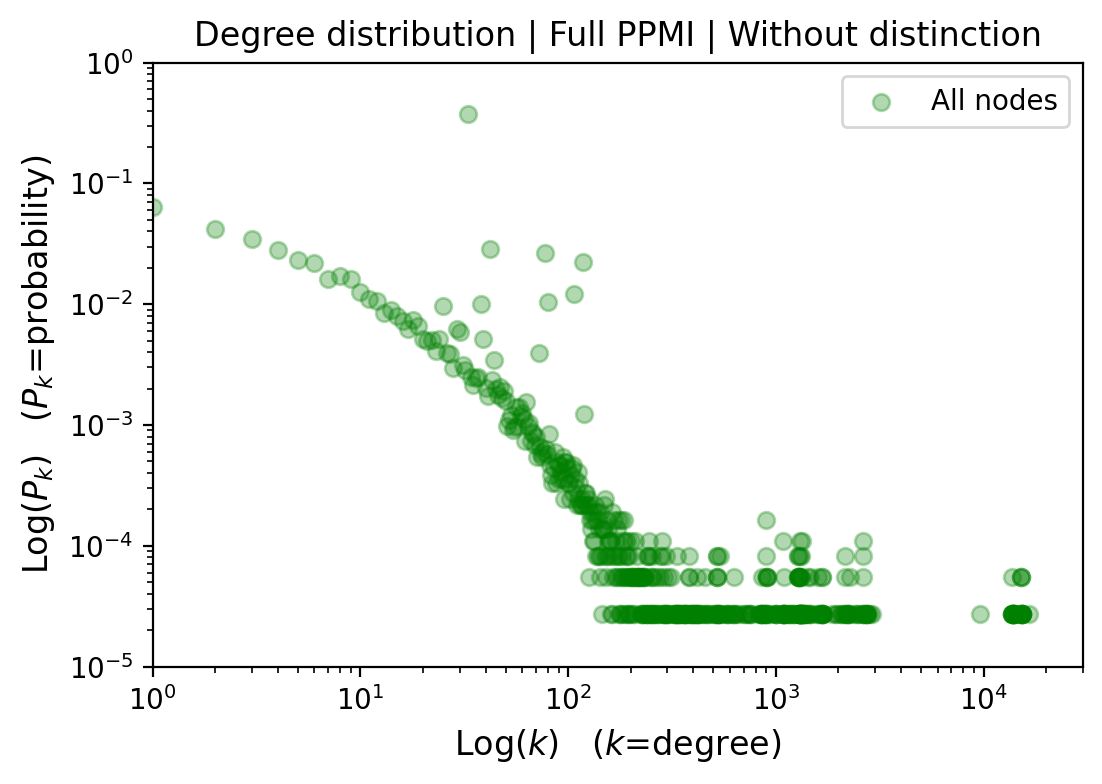

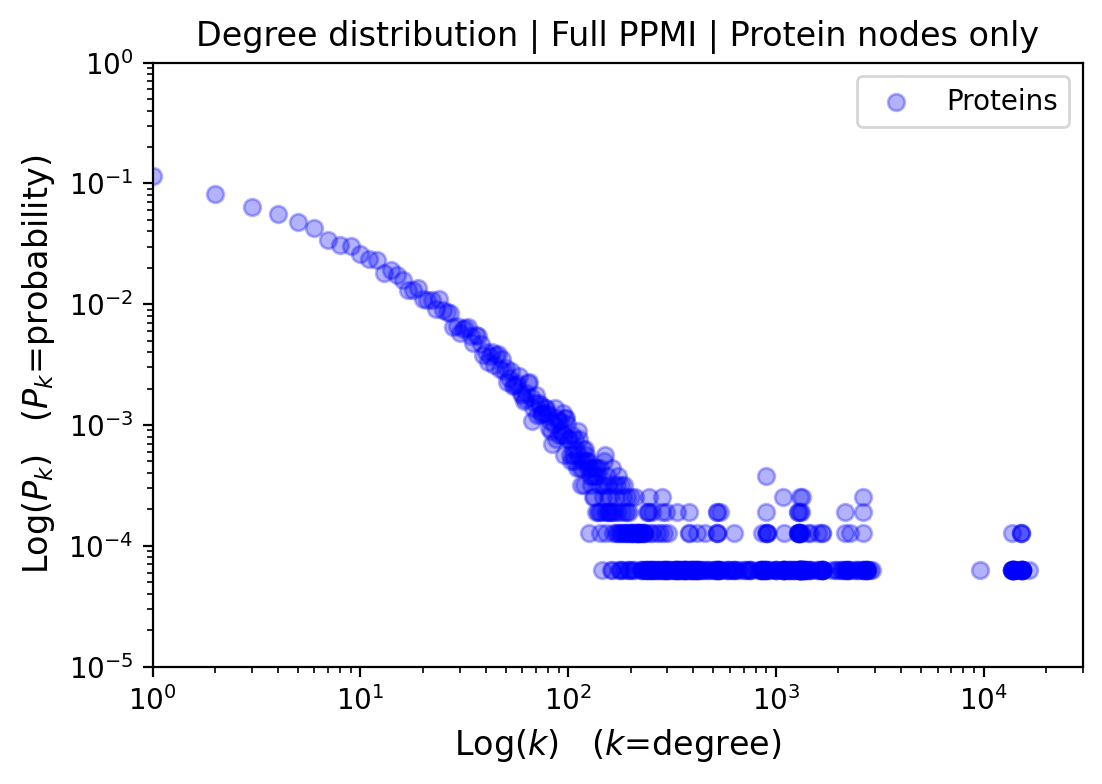

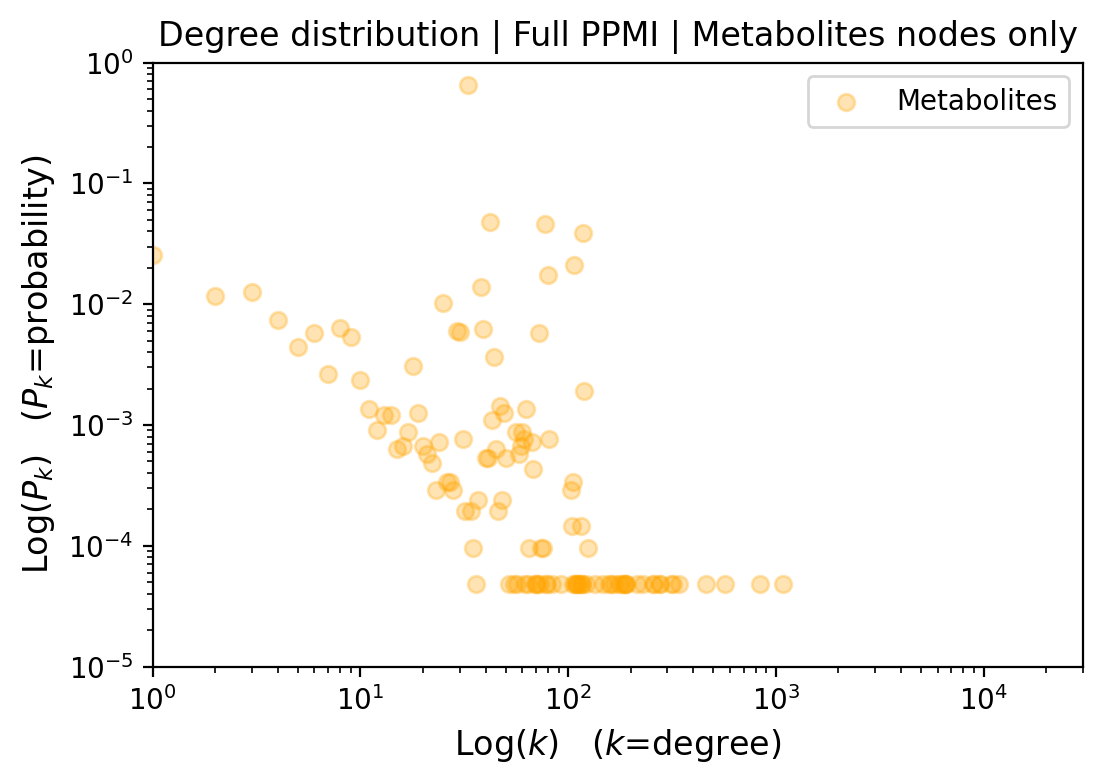

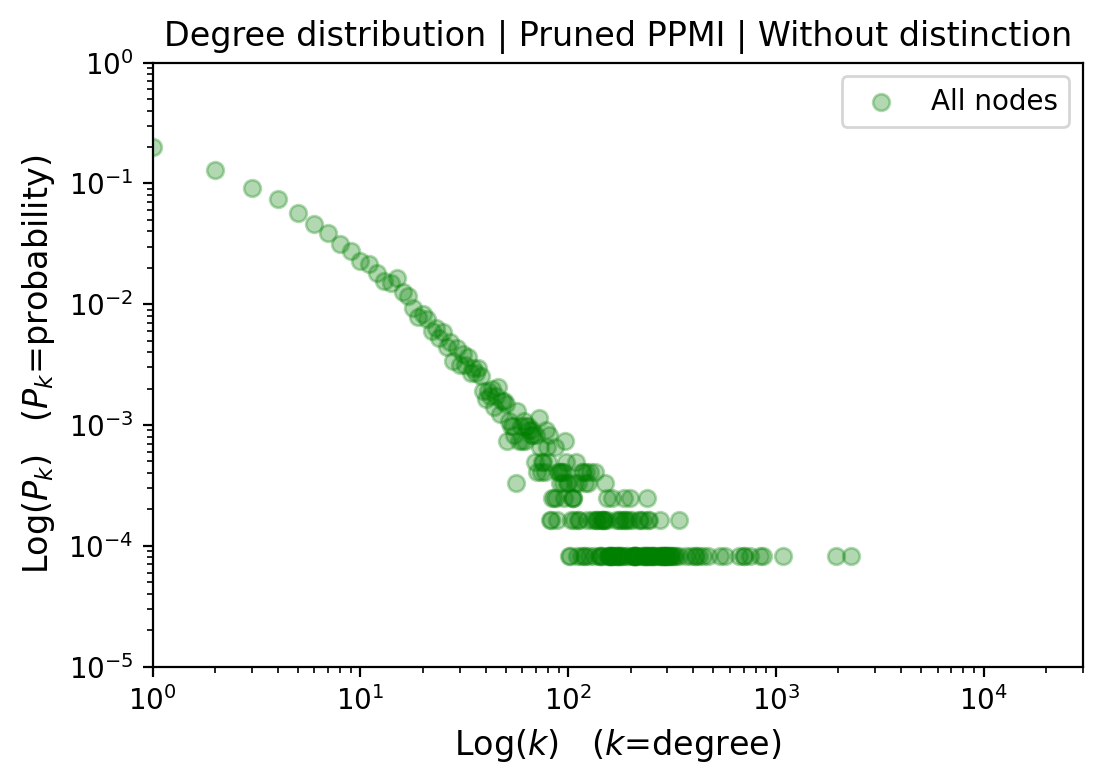

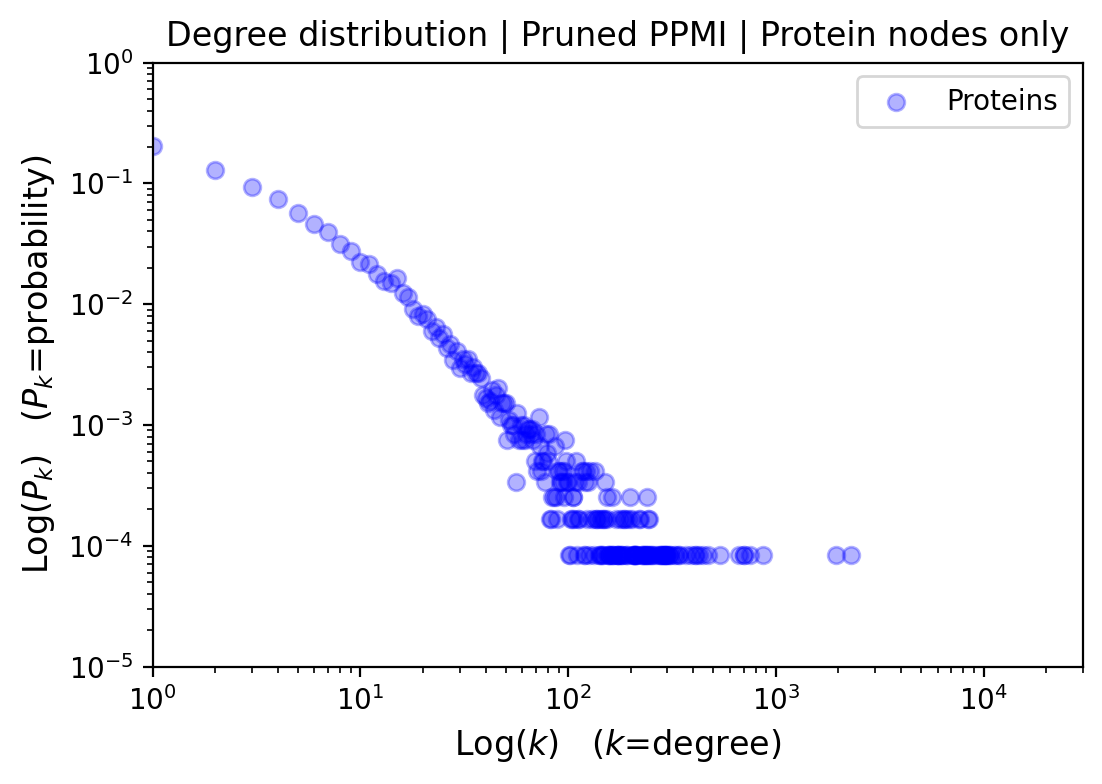

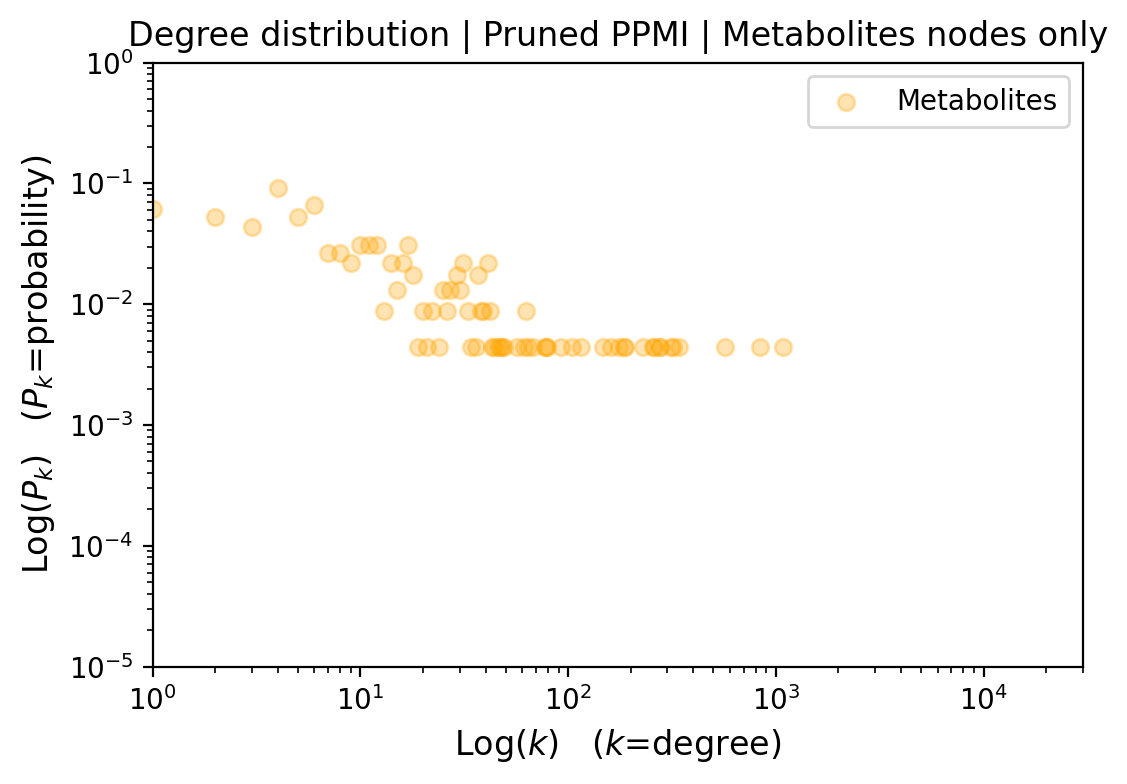

In [56]:
def plot_degree_distribution_per_nodetype(G, plot_metabolites=True, plot_proteins=True, title=''):
    PPMI_type_mask = np.array([0 if 'HMDB' in node else 1 for node in G.nodes], dtype='int32')
    
    n_nodes = len(G.nodes)
    n_metabolite_nodes = np.where(PPMI_type_mask==0, 1, 0).sum()
    n_protein_nodes = np.where(PPMI_type_mask==1, 1, 0).sum()

    nodes, degree_count = zip(*list(G.degree))
    degree_value_counts = pd.Series(degree_count, index=nodes).value_counts()
    P_k = degree_value_counts/n_nodes
    
    metabolite_nodes, metabolite_degree_count = zip(*list(compress(list(G.degree), list(PPMI_type_mask == [0]*n_nodes))))
    protein_nodes, protein_degree_count = zip(*list(compress(list(G.degree), list(PPMI_type_mask == [1]*n_nodes))))

    metabolite_degree_value_counts = pd.Series(metabolite_degree_count, index=metabolite_nodes).value_counts()
    metabolite_P_k = metabolite_degree_value_counts/n_metabolite_nodes

    protein_degree_value_counts = pd.Series(protein_degree_count, index=protein_nodes).value_counts()
    protein_P_k = protein_degree_value_counts/n_protein_nodes  

    alpha=.3
    fig = plt.figure(figsize=(6,4), dpi=200)
    plt.ylim([10**(-5), 10**(0)])    

    plt.yscale('log')
    plt.xscale('log')    

    plt.xlim([1, 30000])
    
    if plot_proteins and plot_metabolites:
        plt.scatter(P_k.index, P_k, color='green', alpha=alpha, label='All nodes')
    else:
        if plot_proteins:
            plt.scatter(protein_P_k.index, protein_P_k, color='blue', alpha=alpha, label='Proteins')
        if plot_metabolites:
            plt.scatter(metabolite_P_k.index, metabolite_P_k, color='orange', alpha=alpha, label='Metabolites')
    
    fontsize_labels=12
    plt.xlabel('Log($k$)   ($k$=degree)', fontsize=fontsize_labels)
    plt.ylabel('Log($P_k$)   ($P_k$=probability)', fontsize=fontsize_labels)
    plt.legend()
    plt.title(title)
    plt.show()

general_title = 'Degree distribution'    
graph_name = 'Full PPMI'
plot_degree_distribution_per_nodetype(dataloader.PPMI_full, title=f'{general_title} | {graph_name} | Without distinction')
plot_degree_distribution_per_nodetype(dataloader.PPMI_full, plot_metabolites=False, title=f'{general_title} | {graph_name} | Protein nodes only')
plot_degree_distribution_per_nodetype(dataloader.PPMI_full, plot_proteins=False, title=f'{general_title} | {graph_name} | Metabolites nodes only')

graph_name = 'Pruned PPMI'
plot_degree_distribution_per_nodetype(dataloader.PPMI_pruned, title=f'{general_title} | {graph_name} | Without distinction')
plot_degree_distribution_per_nodetype(dataloader.PPMI_pruned, plot_metabolites=False, title=f'{general_title} | {graph_name} | Protein nodes only')
plot_degree_distribution_per_nodetype(dataloader.PPMI_pruned, plot_proteins=False, title=f'{general_title} | {graph_name} | Metabolites nodes only')

In [3]:
adjlists, edge_metapath_indices_list, features_list, adjM, type_mask, labels, train_val_test_idx = load_PPMI_data()

In [4]:
def get_metapath_neighbor_count(metapath_id=0):
    n_nodes = len(edge_metapath_indices_list[metapath_id])
    metapath_neighbor_count = scipy.sparse.csr_matrix((n_nodes, n_nodes), dtype=float)
    for source, metapath_instances in edge_metapath_indices_list[metapath_id].items():
        metapath_neighbors, path_instance_counts = np.unique(metapath_instances[:,0], return_counts=True)
        source_target_count = list(zip([source]*len(metapath_neighbors), metapath_neighbors, path_instance_counts))

        for source, target, count in source_target_count:
            metapath_neighbor_count[source, target] = count
    return metapath_neighbor_count

MPM_neighbor_count = get_metapath_neighbor_count(0)
MPPM_neighbor_count = get_metapath_neighbor_count(1)

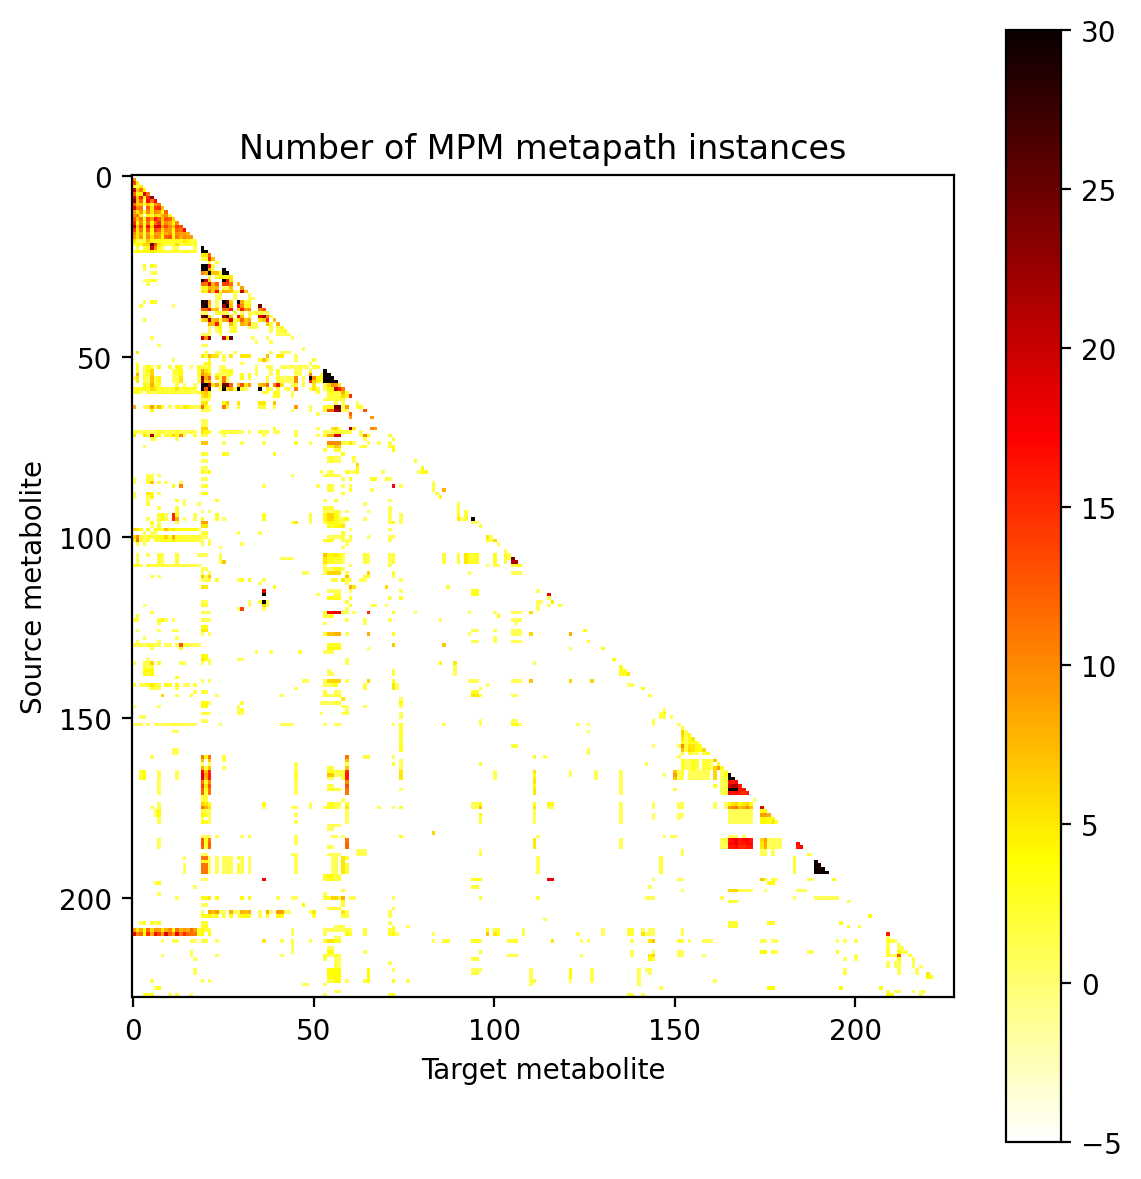

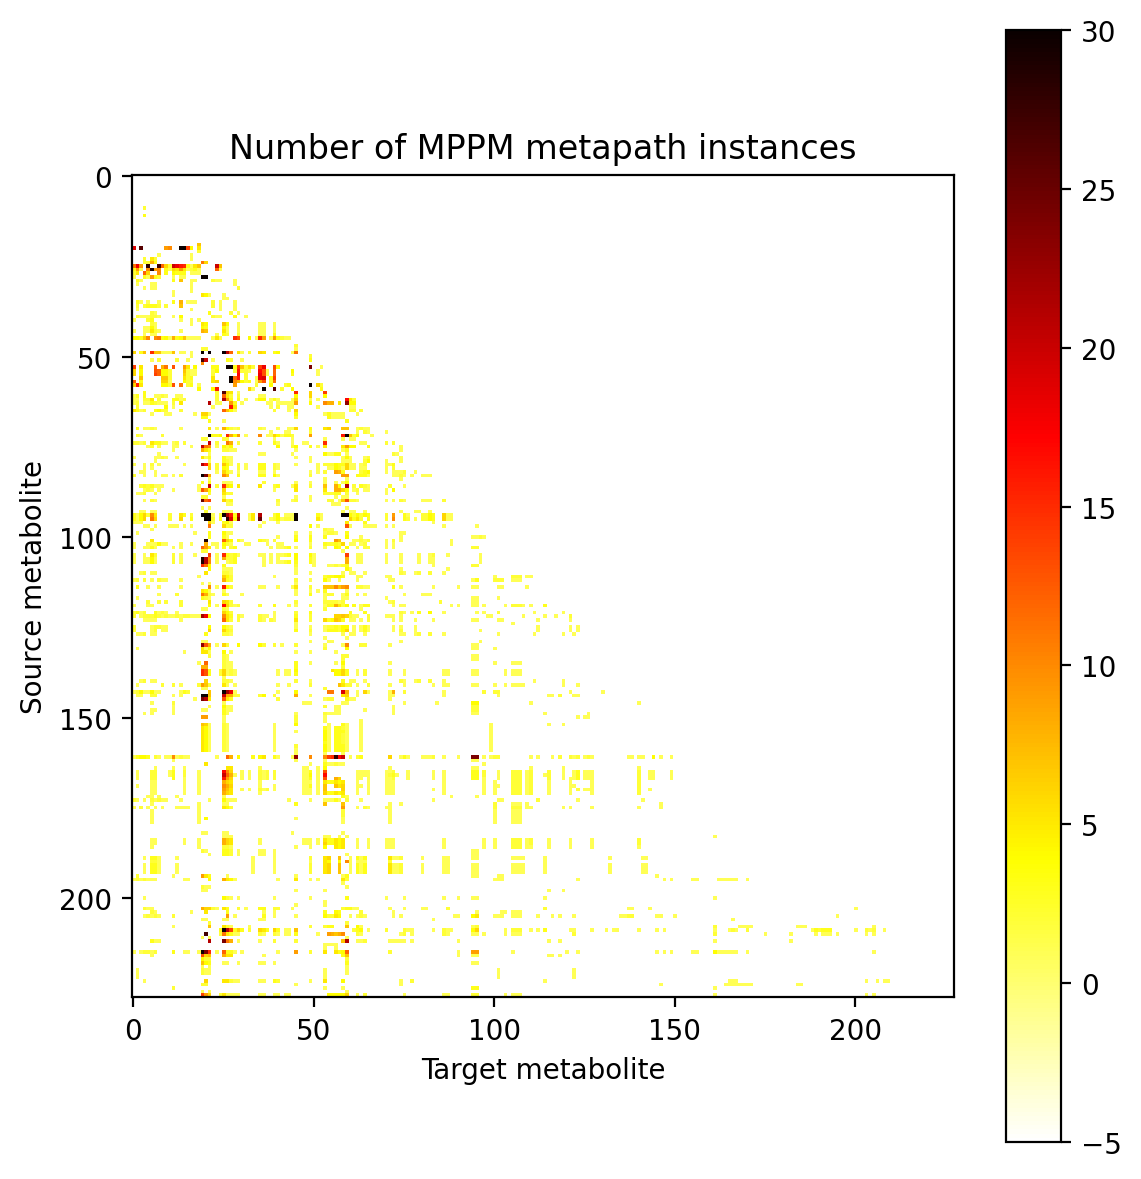

In [5]:
def plot_heatmap_metapath_neighbor_count(sparse_matrix, metapath):
    max_neighborcount = 30
    zero_value = -5

    sparse_matrix = scipy.sparse.tril(sparse_matrix, format='csr')
    sparse_matrix[sparse_matrix > max_neighborcount] = max_neighborcount
    sparse_matrix[sparse_matrix == 0] = zero_value


    plt.figure(figsize=(6,6), dpi=200)
    d=sparse_matrix.todense()
    plt.imshow(d,interpolation='none',cmap='hot_r')
    plt.ylabel('Source metabolite')
    plt.xlabel('Target metabolite')
    plt.colorbar()
    plt.tight_layout()
    plt.title(f'Number of {metapath} metapath instances')
    plt.show()

plot_heatmap_metapath_neighbor_count(MPM_neighbor_count, 'MPM')
plot_heatmap_metapath_neighbor_count(MPPM_neighbor_count, 'MPPM')

## Inspecting outliers

In [6]:
def get_outliers(sparse_matrix, max_neighborcount, dataloader):
    outliers_matrix = scipy.sparse.tril(sparse_matrix, format='csr')
    outliers_matrix[sparse_matrix < max_neighborcount] = 0
    sources, targets, counts = scipy.sparse.find(outliers_matrix)

    HMDB_ids = dataloader.y.index

    df = pd.DataFrame(list(zip(HMDB_ids[sources], HMDB_ids[targets], counts)), columns=['Source', 'Target', 'MPM count'])
    df = df.sort_values('MPM count', ascending=False).reset_index(drop=True).astype({'MPM count': int})
    return df 

print(get_outliers(MPPM_neighbor_count, 30, dataloader))

         Source       Target  MPM count
0   HMDB0000939  HMDB0000538        241
1   HMDB0001185  HMDB0001341        205
2   HMDB0001406  HMDB0000538        194
3   HMDB0000939  HMDB0001341        161
4   HMDB0000939  HMDB0000250         91
5   HMDB0001185  HMDB0000045         85
6   HMDB0000939  HMDB0001273         81
7   HMDB0000158  HMDB0001273         77
8   HMDB0000939  HMDB0000045         72
9   HMDB0001406  HMDB0001273         66
10  HMDB0001248  HMDB0001201         58
11  HMDB0001406  HMDB0000045         49
12  HMDB0001341  HMDB0000162         46
13  HMDB0000208  HMDB0000250         46
14  HMDB0000208  HMDB0000045         42
15  HMDB0000939  HMDB0001429         41
16  HMDB0000902  HMDB0001397         40
17  HMDB0001248  HMDB0001397         38
18  HMDB0000259  HMDB0000538         37
19  HMDB0000132  HMDB0000538         37
20  HMDB0000068  HMDB0001273         37
21  HMDB0000265  HMDB0000538         36
22  HMDB0001185  HMDB0000058         36
23  HMDB0000939  HMDB0000058         34


## Creating Venn diagrams

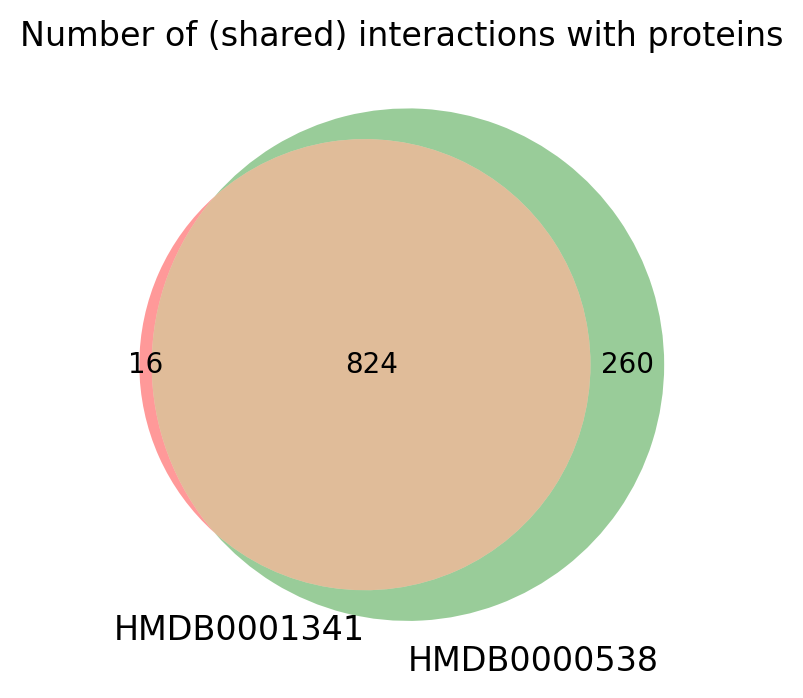

In [7]:
def plot_venn_protein_links(metabolite_A, metabolite_B):
    set_a = set(list(dataloader.PPMI_pruned[metabolite_A]))
    set_b = set(list(dataloader.PPMI_pruned[metabolite_B]))

    # Second way
    fig = plt.figure(figsize=(4,4), dpi=200)
    fig.patch.set_facecolor('white')    
    v = venn2([set_a, set_b], set_labels = (metabolite_A, metabolite_B))
    plt.title('Number of (shared) interactions with proteins')
    plt.show()

def get_matapath_based_neighbors(dataloader, target_node_name, metapath_index=0):
    target_node_index = list(dataloader.y.index).index(target_node_name)
    metapaths_inspect = edge_metapath_indices_list[metapath_index][target_node_index]
    metapath_based_neighbors = pd.Series(metapaths_inspect[:, 0]).value_counts()
    metapath_based_neighbors.index = dataloader.y.index[np.array(metapath_based_neighbors.index)]
    name = f'{dataloader.y.index[target_node_index]}_metapath_{metapath_index}_based_neighbours'
    metapath_based_neighbors.name = name
    return metapath_based_neighbors

plot_venn_protein_links('HMDB0001341', 'HMDB0000538')

In [8]:
dataloader.y[['HMDB0001341', 'HMDB0000538']]

hmdb_accession
HMDB0001341    -1
HMDB0000538    -1
Name: CCS, dtype: object